# Machine Learning II Data Challenge  
Time series analysis to predict house electricity consumption.

- Thomas de Mareuil
- Constantin Vodé
- Tommy Tran

## Introduction
### Challenge context

BCM Energy is a start-up based in Lyon and created in 2015. BCM operates on the whole value chain of renewable electricity, from production assets management on electricity markets (Epexspot, EEX) to electricity supply to final consumers through the brand Planète OUI:

BCM Energy is active continuously on the electricity markets,
BCM Energy is responsible of its own balancing perimeter,
BCM Energy also manages capacity certificates within its own certification perimeter and guarantees of origin in its register.
The diverse priority areas of growth are supported by a trading team with more than fifteen years of experience of the various electricity markets, developing state-of-the-art financial analysis modeling. Planète OUI, created in 2007, is one of the first French green electricity supplier. The company supplies tens of thousands of homes and professionals and covers more than 95 % of metropolitan France (Enedis network). Planète OUI promotes an ecology constructive and made available for all. It has integrated BCM Energy’s perimeter in 2017. The supplier has to offer green electricity supply with prices adapted to the consumption profiles of its clients. Indeed, the information of disaggregation consumption could help reduce electricity consumption and so reduce the electricity bill with customized advice or control of appliances of our clients (with their agreement).

### Challenge goals
The goal is to train an algorithm to replace many monitoring systems which are too intrusive and too expensive. This challenge is known as NILM (Nonintrusive load monitoring) or NIALM (Nonintrusive appliance load monitoring). The aim of the challenge is to find the part of electric consumption in one household dedicated to 4 appliances (washing machine, fridge_freezer, TV, kettle). There are no time constraints. The past and the future are known.

### Data description
The first line of the input contains the header, the columns are separated by ',', and decimals by decimal point. The columns are:

- the “time_step”: date measured each minute (format yyyy-MM-ddTHH :mm :ss.Z)
- the “consumption”: household consumption (W) measured each minute
- the “visibility”: distance at which it is possible to clearly distinguish an object (km) measured once per hour
- the “temperature”: temperature (°C) measured once per hour
- the “humidity”: presence of water in the air (%) measured once per hour
- the “humidex”: index used to integrate the combined effects of heat and humidity measured once per hour
- the “windchill”: an index that expresses the subjective feeling of cold or heat as a function of measured temperature, wind and humidity (°C) measured once per hour
- the “wind”: wind speed (km/h) measured once per hour
- the “pressure”: applied perpendicular to the surface of an object per unit area (Pa) measured once per hour


The first line of the output contains the header, the columns are separated by ',', and decimals by decimal point. The columns are:

- the “time_step”: date measured each minute (format yyyy-MM-ddTHH :mm :ss.Z)
- the “washing_machine”: washing machine power (W) measured each minute
- the “fridge_freezer”: fridge freezer power (W) measured each minute
- the “TV”: TV power (W) measured each minute
- the “kettle”: kettle power (W) measured each minute

- The train set contains 417 599 values with 10 231 missing values (2,44%) for “consumption”, “washing_machine”, “fridge_freezer”, “TV”, “kettle” and the test set contains 226 081 values with 24 719 missing values (10,93%).

## Data exploration

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
%matplotlib inline

In [115]:
input_train = pd.read_csv('X_train.csv')
input_train = input_train.drop('Unnamed: 9', axis=1)
output_train = pd.read_csv('y_train.csv')

In [116]:
# Convert the time_step feature into datetime in the input and output datasets

input_train['time_step'] = pd.to_datetime(input_train['time_step'])
output_train['time_step'] = pd.to_datetime(output_train['time_step'])

# Check data type
print(input_train['time_step'].dtype)
print(output_train['time_step'].dtype)

datetime64[ns]
datetime64[ns]


### Data visualisation

### Missing values

time_step      0.000000
consumption    0.024500
visibility     0.983391
temperature    0.983364
humidity       0.983391
humidex        0.983391
windchill      0.983410
wind           0.983391
pressure       0.983400
dtype: float64


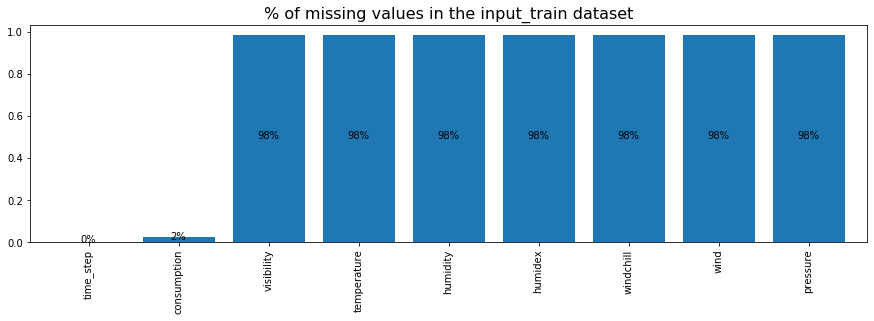

In [117]:
# Show % of missing values in the input_train dataset

missing = input_train.isna().sum()
missing = missing / len(input_train)
print(missing)

ax = missing.plot(kind='bar',figsize=(15,4),width = 0.8,edgecolor=None)
plt.title("% of missing values in the input_train dataset",fontsize= 16)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(height), (p.get_x()+.5*width, p.get_y()+.5*height), ha = 'center')

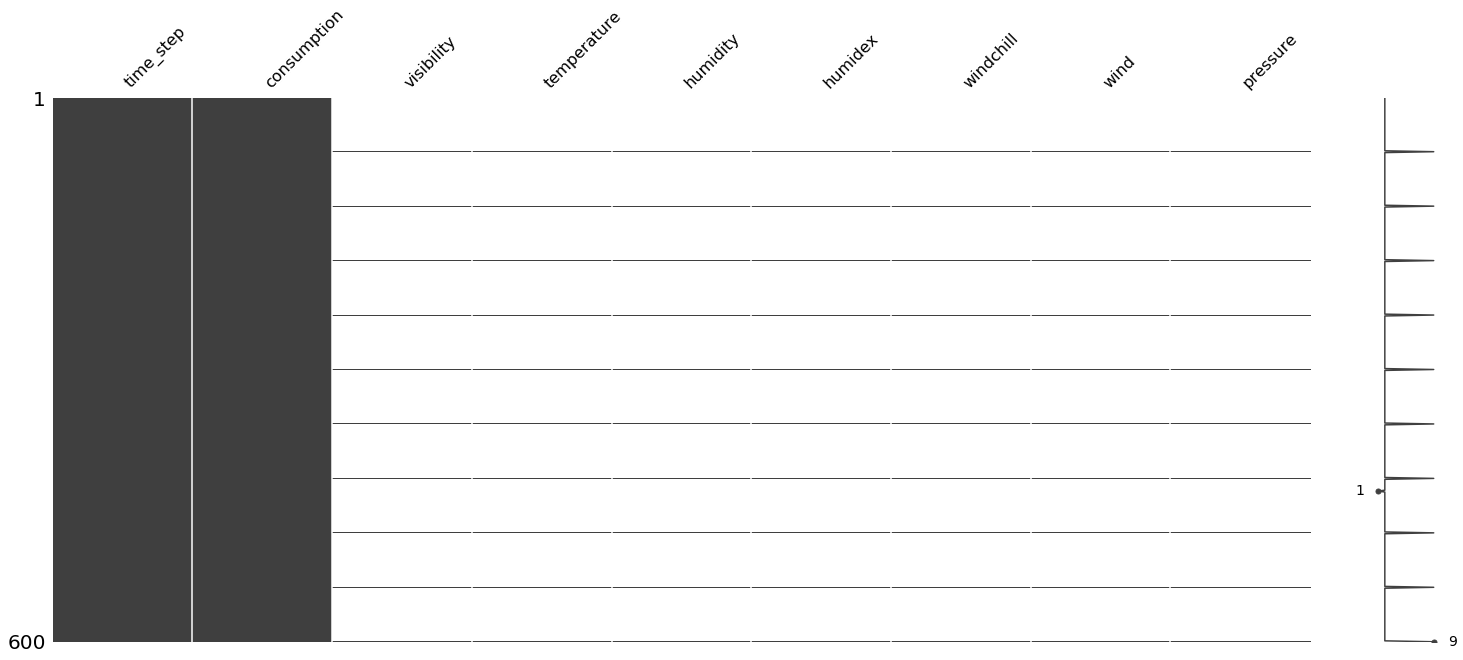

In [118]:
# Visualize missing values repartition in the first 10h of the dataset

import missingno as msno
msno.matrix(input_train[:600])

We can see that all meteorological features are measured once per hour (i.e. 10 values/lines are visible on the graph above, for the 10 first hours of the dataset), which explains the high proportion of missing values.

To impute these missing values in-between the measurements, we will use the [backward interpolation] method. (why?)

In [119]:
# Imputation of missing weather data with interpolation method

to_interpolate = input_train.columns[-8:] # selects weather features
input_train[to_interpolate] = pd.Series.interpolate(input_train[to_interpolate],
                                                    method='linear', limit=None, 
                                                    limit_direction='both')


#missing val y_train
#to_interpolate = output_train.columns[-4:]
#output_train[to_interpolate] = pd.Series.interpolate(output_train[to_interpolate],
 #                                                   method='linear', limit=None, 
  #                                                  limit_direction='both')


### Feature encoding

In [101]:
# One-hot encoding and circular time encoding

input_train['weekend'] = ((pd.DatetimeIndex(input_train['time_step']).dayofweek) // 5 == 1).astype(float)

input_train['weekday'] = input_train['time_step'].dt.weekday
input_train['month'] = input_train['time_step'].dt.month
input_train['day_of_year'] = input_train['time_step'].dt.dayofyear
#input_train['quarter'] = input_train['time_step'].dt.quarter remove because quasi-nul importance
input_train['hour'] = input_train['time_step'].dt.hour
input_train['week'] = input_train['time_step'].dt.week
input_train['minute'] = input_train['time_step'].dt.minute



input_train = input_train.join(pd.get_dummies(input_train['weekday'], prefix='wd'))

input_train['sin_time'] = np.sin(2*np.pi*input_train['time_step'].dt.hour/24)
input_train['cos_time'] = np.cos(2*np.pi*input_train['time_step'].dt.hour/24)

input_train.drop(['time_step','weekday'], axis=1, inplace=True)
output_train.drop(['time_step'], axis=1, inplace=True)

### Feature engineering tests

In [380]:
#Mean max and min consumption by (temperature, weekend, wd_0 etc.):
groupcollist = ['hour', 'month', 'week', 'day_of_year', 'weekend', 'temperature', 'wind']
aggregationlist = [('consumption',np.mean,'avg')]

for type_id in groupcollist:
    for column_id,aggregator,aggtype in aggregationlist:
        # get numbers from sales data and set column names
        mean_df = input_train.groupby([type_id]).aggregate(aggregator).reset_index()[[column_id,type_id,]]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id]
        # merge new columns on sales_m data
        input_train = pd.merge(input_train,mean_df,on=type_id,how='left')

In [381]:
# Previous day same hour
input_train['previous_day_same_hour'] = lagged_df['consumption'].shift(-1440) #1440 minutes/day   


In [382]:
from IPython.display import display
pd.options.display.max_columns = None
input_train.head()


,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,weekend,month,day_of_year,hour,week,minute,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,sin_time,cos_time,hour_avg_consumption,month_avg_consumption,week_avg_consumption,day_of_year_avg_consumption,weekend_avg_consumption,temperature_avg_consumption,wind_avg_consumption,previous_day_same_hour
0,550.4000,35.0,8.9,86.0,8.9,6.0,19.0,1017.3,1.0,3,76,0,11,1,0,0,0,0,0,0,1,0.0,1.0,275.842073,361.419421,474.407149,474.407149,315.715797,378.216869,316.702021,NaN
1,548.6000,35.0,8.9,86.0,8.9,6.0,19.0,1017.3,1.0,3,76,0,11,2,0,0,0,0,0,0,1,0.0,1.0,275.842073,361.419421,474.407149,474.407149,315.715797,378.216869,316.702021,NaN
2,549.3000,35.0,8.9,86.0,8.9,6.0,19.0,1017.3,1.0,3,76,0,11,3,0,0,0,0,0,0,1,0.0,1.0,275.842073,361.419421,474.407149,474.407149,315.715797,378.216869,316.702021,NaN
3,549.3667,35.0,8.9,86.0,8.9,6.0,19.0,1017.3,1.0,3,76,0,11,4,0,0,0,0,0,0,1,0.0,1.0,275.842073,361.419421,474.407149,474.407149,315.715797,378.216869,316.702021,NaN
4,548.8909,35.0,8.9,86.0,8.9,6.0,19.0,1017.3,1.0,3,76,0,11,5,0,0,0,0,0,0,1,0.0,1.0,275.842073,361.419421,474.407149,474.407149,315.715797,378.216869,316.702021,NaN


## Correlation 

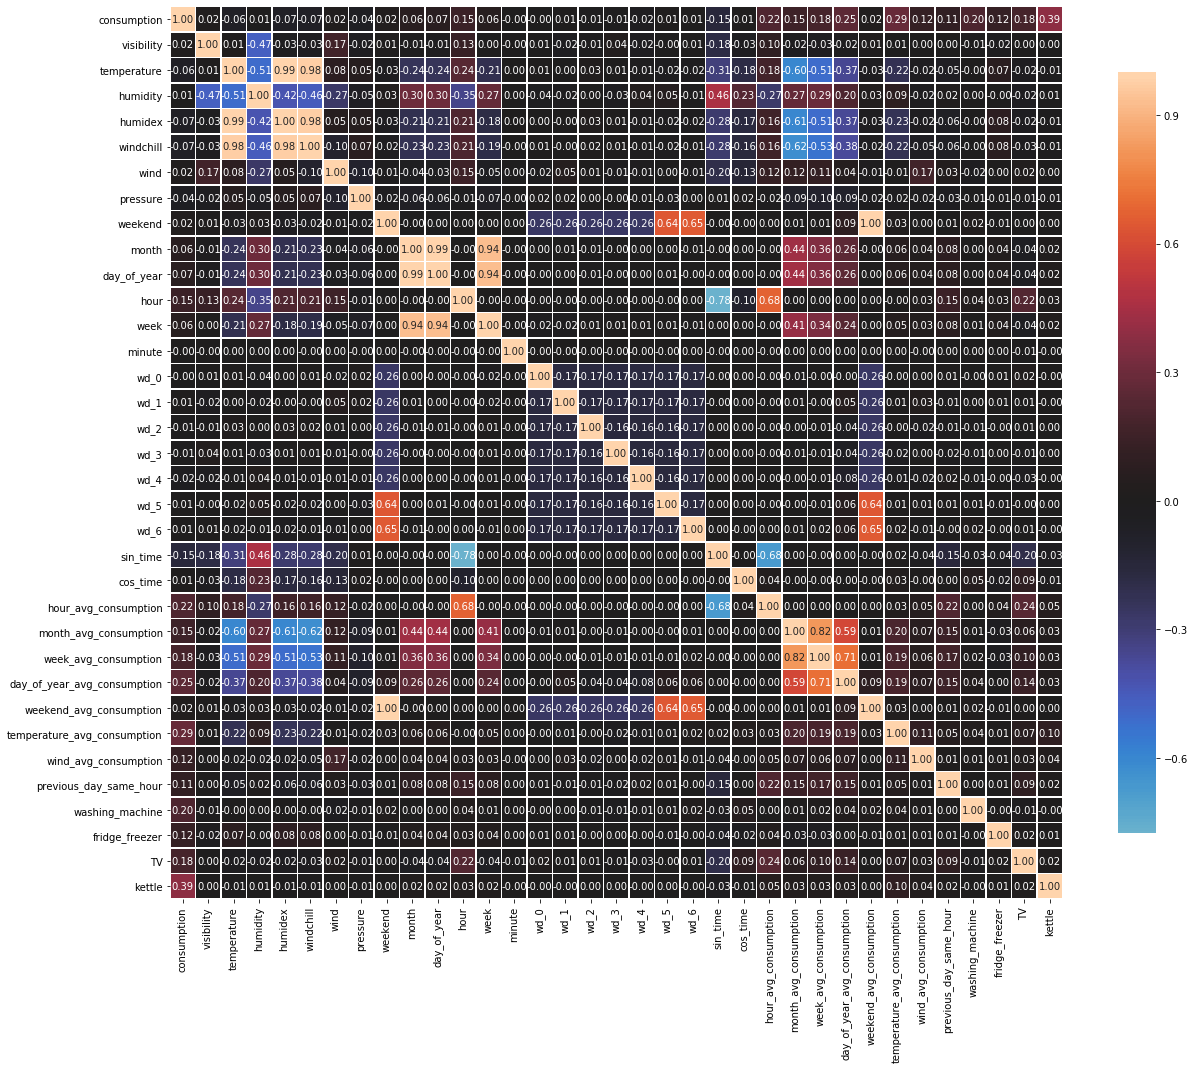

In [383]:
total_data = pd.DataFrame()
total_data[input_train.columns] = input_train
total_data[output_train.columns] = output_train
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
correlation_heatmap(total_data)

## Modeling

We want to predict, for each minute, the power used by the washing_machine, the fridge, the TV and the kettle. This is a multi-output regression.

In [384]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

In [10]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

### XGBoost

In [8]:
from xgboost import XGBRegressor
from xgboost import plot_importance
import plotly_express as px

We need to :
* check locally (with train test split on train data) which appliance is best predicted, including the delta
* train on the whole train data
* predict on test data
* subtract from total consumption the appliance we just predicted
* repeat

#### Wrap-up pre-processing

In [157]:
def preprocess(X):
    X.drop(["Unnamed: 9"], axis=1, inplace=True)
    to_interpolate = X.columns[-7:]
    X[to_interpolate] = pd.Series.interpolate(X[to_interpolate], method='linear', 
                                              limit=None, limit_direction='both')
    X.rename(columns = {X.columns[0]:'time_step'}, inplace=True)
    X['time_step'] = pd.to_datetime(X['time_step'])
    X['weekend'] = ((pd.DatetimeIndex(X['time_step']).dayofweek) // 5 == 1).astype(float)
    X['weekday'] = X['time_step'].dt.weekday
    X = X.join(pd.get_dummies(X['weekday'], prefix='wd'))
    X['sin_time'] = np.sin(2*np.pi*X['time_step'].dt.hour/24)
    X['cos_time'] = np.cos(2*np.pi*X['time_step'].dt.hour/24)
    X.drop(['weekday', 'time_step'], axis=1, inplace=True)
    X = X.dropna() # need to remove all NaN to train
    return X

input_train = pd.read_csv('X_train.csv')
input_train = preprocess(input_train)

input_test = pd.read_csv('X_test.csv')
input_test.rename(columns = {input_test.columns[0]:'time_step'}, inplace=True)
full_timesteps = input_test['time_step'] # for later
input_test = preprocess(input_test)
#partial_timesteps = input_test['time_step'] # for later

,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,weekend,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,sin_time,cos_time
0,312.2222,30.00,8.400000,86.000000,8.400000,5.600000,17.0,1016.600,0.0,0,0,1,0,0,0,0,0.000000,1.000000
1,318.8750,29.95,8.401667,85.983333,8.401667,5.616667,16.9,1016.615,0.0,0,0,1,0,0,0,0,0.000000,1.000000
2,314.3000,29.90,8.403333,85.966667,8.403333,5.633333,16.8,1016.630,0.0,0,0,1,0,0,0,0,0.000000,1.000000
3,311.4444,29.85,8.405000,85.950000,8.405000,5.650000,16.7,1016.645,0.0,0,0,1,0,0,0,0,0.000000,1.000000
4,310.0000,29.80,8.406667,85.933333,8.406667,5.666667,16.6,1016.660,0.0,0,0,1,0,0,0,0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226076,176.0000,14.24,8.433333,90.000000,8.440000,4.346667,31.0,1019.940,0.0,0,0,0,0,1,0,0,-0.258819,0.965926
226077,176.3333,14.43,8.425000,90.000000,8.430000,4.335000,31.0,1019.955,0.0,0,0,0,0,1,0,0,-0.258819,0.965926
226078,174.8889,14.62,8.416667,90.000000,8.420000,4.323333,31.0,1019.970,0.0,0,0,0,0,1,0,0,-0.258819,0.965926
226079,189.3750,14.81,8.408333,90.000000,8.410000,4.311667,31.0,1019.985,0.0,0,0,0,0,1,0,0,-0.258819,0.965926


In [123]:
# add a column with delta in output_train

output_train['sum'] = output_train.sum(axis=1)
output_train['consumption'] = input_train['consumption']
output_train['delta'] = output_train['consumption'] - output_train['sum']
output_train.drop(columns=['time_step','sum','consumption'], inplace = True)
output_train = output_train.dropna()
output_train

,time_step,washing_machine,fridge_freezer,TV,kettle,delta
0,2013-03-17 00:01:00,0.0,79.2000,7.0000,0.0,464.2000
1,2013-03-17 00:02:00,0.0,78.0000,7.0000,0.0,463.6000
2,2013-03-17 00:03:00,0.0,76.9000,7.0000,0.0,465.4000
3,2013-03-17 00:04:00,0.0,76.1111,7.0000,0.0,466.2556
4,2013-03-17 00:05:00,0.0,75.2727,7.0000,0.0,466.6182
...,...,...,...,...,...,...
417594,2013-12-31 23:55:00,0.0,54.0000,65.7778,0.0,222.8889
417595,2013-12-31 23:56:00,0.0,4.6667,65.1111,0.0,241.7778
417596,2013-12-31 23:57:00,0.0,0.0000,65.5000,0.0,245.0000
417597,2013-12-31 23:58:00,0.0,0.0000,65.7778,0.0,246.2222


#### Hold-Out Train-Test Split

In [43]:
train_size = int(len(input_train)*0.8)
test_size = int(len(input_train)-train_size)

In [44]:
X_train = input_train[:train_size]
X_test = input_train[train_size:]

y_train = output_train[:train_size]
y_test = output_train[train_size:]

In [ ]:
#from sklearn.preprocessing import StandardScaler
#sc=StandardScaler()
#X_train = sc.fit_transform(input_train[:train_size])
#X_test = sc.fit_transform(input_train[train_size:])

#### Find best-predicted variable locally

In [134]:
def find_best(input_train, output_train, input_test):
    
    # train-test split
    train_size = int(len(input_train)*0.8)
    test_size = int(len(input_train)-train_size)
    X_train = input_train[:train_size]
    X_test = input_train[train_size:]
    y_train = output_train[:train_size]
    y_test = output_train[train_size:]
    
    # XGB training and predicting for each variable
    score = []
    pred = []
    for i in range(len(output_train.columns)):
        name = output_train.columns[i]
        print('****************** Training for {} ******************'.format(name))
        XG = XGBRegressor(max_depth=8, n_estimators=1000, min_child_weight=300,colsample_bytree=0.8, 
                           eta=0.3, seed=42).fit(X_train, y_train[name],eval_metric="rmse", 
                            eval_set=[(X_train, y_train[name]), (X_test, y_test[name])], 
                             verbose=True, early_stopping_rounds = 10)
        
        # store score
        pred_XG = XG.predict(X_test)
        score_XG = rmse(y_test[name], pred_XG)
        score.append(score_XG)
        
        # store prediction
        pred_XG = XG.predict(input_test)
        pred.append(pred_XG)
    
    print('The best performance is on {} with RMSE at {}.'.format(output_train.columns[score.index(min(score))], min(score)))
    
    return pred[score.index(min(score))]

In [135]:
pred1 = find_best(input_train, output_train, input_test)

****************** Training for washing_machine ******************
[16:44:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:56.4227	validation_1-rmse:54.4684
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:54.9541	validation_1-rmse:53.584
[2]	validation_0-rmse:53.697	validation_1-rmse:52.9384
[3]	validation_0-rmse:52.9731	validation_1-rmse:52.361
[4]	validation_0-rmse:51.9852	validation_1-rmse:52.0428
[5]	validation_0-rmse:51.2318	validation_1-rmse:51.8078
[6]	validation_0-rmse:50.7187	validation_1-rmse:51.6759
[7]	validation_0-rmse:50.3019	validation_1-rmse:51.6394
[8]	validation_0-rmse:49.9726	validation_1-rmse:51.5982
[9]	validation_0-rmse:49.8261	validation_1-rmse:51.5686
[10]	validation_0-rmse:49.2849	validation_1-rmse:51.424
[11]	validation_0-rmse:48.917	validation_1-rm

[40]	validation_0-rmse:69.0795	validation_1-rmse:117.692
[41]	validation_0-rmse:69.0669	validation_1-rmse:117.697
[42]	validation_0-rmse:69.0074	validation_1-rmse:117.384
[43]	validation_0-rmse:68.9922	validation_1-rmse:117.382
[44]	validation_0-rmse:68.9394	validation_1-rmse:117.089
[45]	validation_0-rmse:68.9267	validation_1-rmse:117.143
[46]	validation_0-rmse:68.8855	validation_1-rmse:116.888
[47]	validation_0-rmse:68.8734	validation_1-rmse:116.946
[48]	validation_0-rmse:68.8466	validation_1-rmse:116.938
[49]	validation_0-rmse:68.8105	validation_1-rmse:116.706
[50]	validation_0-rmse:68.7968	validation_1-rmse:116.766
[51]	validation_0-rmse:68.7804	validation_1-rmse:116.764
[52]	validation_0-rmse:68.7469	validation_1-rmse:116.513
[53]	validation_0-rmse:68.7346	validation_1-rmse:116.581
[54]	validation_0-rmse:68.7044	validation_1-rmse:116.374
[55]	validation_0-rmse:68.6921	validation_1-rmse:116.445
[56]	validation_0-rmse:68.6629	validation_1-rmse:116.226
[57]	validation_0-rmse:68.6511	

[39]	validation_0-rmse:86.7973	validation_1-rmse:134.304
[40]	validation_0-rmse:86.4861	validation_1-rmse:134.254
[41]	validation_0-rmse:86.1995	validation_1-rmse:134.346
[42]	validation_0-rmse:85.9836	validation_1-rmse:134.296
[43]	validation_0-rmse:85.6539	validation_1-rmse:134.161
[44]	validation_0-rmse:85.4173	validation_1-rmse:134.135
[45]	validation_0-rmse:85.1572	validation_1-rmse:134.108
[46]	validation_0-rmse:84.9334	validation_1-rmse:134.253
[47]	validation_0-rmse:84.7264	validation_1-rmse:134.248
[48]	validation_0-rmse:84.6998	validation_1-rmse:134.234
[49]	validation_0-rmse:84.5276	validation_1-rmse:134.168
[50]	validation_0-rmse:84.3738	validation_1-rmse:134.058
[51]	validation_0-rmse:84.3419	validation_1-rmse:134.062
[52]	validation_0-rmse:84.1999	validation_1-rmse:134.012
[53]	validation_0-rmse:84.0204	validation_1-rmse:133.99
[54]	validation_0-rmse:83.868	validation_1-rmse:133.877
[55]	validation_0-rmse:83.7239	validation_1-rmse:134.025
[56]	validation_0-rmse:83.6178	va

In [136]:
pred1 = pd.DataFrame(pred1, columns=['pred1'])
pred1

,pred1
0,14.836174
1,14.836174
2,14.836174
3,14.836174
4,14.836174
...,...
201357,5.206774
201358,5.206774
201359,5.206774
201360,7.383894


#### Substract predictions and repeat

Step 2:

In [142]:
input_train = pd.read_csv('X_train.csv')
output_train2 = pd.read_csv('y_train.csv')
input_train['consumption'] = input_train['consumption'] - output_train2['TV']
input_train = preprocess(input_train)

input_test = pd.read_csv('X_test.csv')
input_test = preprocess(input_test)
input_test['consumption'] = input_test['consumption'] - pred1['pred1']

output_train.drop(columns=['TV'], inplace = True)
output_train['delta'] = output_train['delta'] - pred1['pred1']

In [143]:
pred2 = find_best(input_train, output_train, input_test)

****************** Training for washing_machine ******************
[17:07:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:56.4001	validation_1-rmse:54.4242
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:54.9031	validation_1-rmse:53.5328
[2]	validation_0-rmse:53.6482	validation_1-rmse:52.8563
[3]	validation_0-rmse:52.9129	validation_1-rmse:52.2741
[4]	validation_0-rmse:51.905	validation_1-rmse:51.8821
[5]	validation_0-rmse:51.092	validation_1-rmse:51.6287
[6]	validation_0-rmse:50.6125	validation_1-rmse:51.3237
[7]	validation_0-rmse:50.2085	validation_1-rmse:51.1991
[8]	validation_0-rmse:49.7705	validation_1-rmse:51.2051
[9]	validation_0-rmse:49.625	validation_1-rmse:51.172
[10]	validation_0-rmse:49.1088	validation_1-rmse:51.0346
[11]	validation_0-rmse:48.7478	validation_1-r

[68]	validation_0-rmse:67.9044	validation_1-rmse:114.57
[69]	validation_0-rmse:67.8944	validation_1-rmse:114.629
[70]	validation_0-rmse:67.8759	validation_1-rmse:114.472
[71]	validation_0-rmse:67.8661	validation_1-rmse:114.532
[72]	validation_0-rmse:67.8237	validation_1-rmse:114.521
[73]	validation_0-rmse:67.8102	validation_1-rmse:114.529
[74]	validation_0-rmse:67.8054	validation_1-rmse:114.528
[75]	validation_0-rmse:67.785	validation_1-rmse:114.4
[76]	validation_0-rmse:67.7753	validation_1-rmse:114.458
[77]	validation_0-rmse:67.7576	validation_1-rmse:114.341
[78]	validation_0-rmse:67.748	validation_1-rmse:114.401
[79]	validation_0-rmse:67.7333	validation_1-rmse:114.265
[80]	validation_0-rmse:67.724	validation_1-rmse:114.323
[81]	validation_0-rmse:67.7094	validation_1-rmse:114.217
[82]	validation_0-rmse:67.7006	validation_1-rmse:114.276
[83]	validation_0-rmse:67.676	validation_1-rmse:114.296
[84]	validation_0-rmse:67.6684	validation_1-rmse:114.294
[85]	validation_0-rmse:67.661	validati

[59]	validation_0-rmse:83.4837	validation_1-rmse:133.183
[60]	validation_0-rmse:83.4052	validation_1-rmse:133.096
[61]	validation_0-rmse:83.3607	validation_1-rmse:133.052
[62]	validation_0-rmse:83.3236	validation_1-rmse:133.125
[63]	validation_0-rmse:83.3045	validation_1-rmse:133.121
[64]	validation_0-rmse:83.2857	validation_1-rmse:133.11
[65]	validation_0-rmse:83.2129	validation_1-rmse:133.052
[66]	validation_0-rmse:83.1552	validation_1-rmse:133.115
[67]	validation_0-rmse:83.0908	validation_1-rmse:133.081
[68]	validation_0-rmse:82.9979	validation_1-rmse:132.861
[69]	validation_0-rmse:82.9178	validation_1-rmse:132.817
[70]	validation_0-rmse:82.8272	validation_1-rmse:132.618
[71]	validation_0-rmse:82.7786	validation_1-rmse:132.603
[72]	validation_0-rmse:82.7507	validation_1-rmse:132.602
[73]	validation_0-rmse:82.7367	validation_1-rmse:132.607
[74]	validation_0-rmse:82.7298	validation_1-rmse:132.61
[75]	validation_0-rmse:82.6899	validation_1-rmse:132.424
[76]	validation_0-rmse:82.6613	va

In [144]:
pred2 = pd.DataFrame(pred2, columns=['pred2'])
pred2

,pred2
0,70.326843
1,70.326843
2,70.326843
3,70.537468
4,70.537468
...,...
201357,2.233356
201358,1.517320
201359,1.517320
201360,1.517320


Step 3:

In [146]:
input_train = pd.read_csv('X_train.csv')
output_train2 = pd.read_csv('y_train.csv')
input_train['consumption'] = input_train['consumption'] - output_train2['TV'] - output_train2['fridge_freezer']
input_train = preprocess(input_train)

input_test = pd.read_csv('X_test.csv')
input_test = preprocess(input_test)
input_test['consumption'] = input_test['consumption'] - pred1['pred1'] - pred2['pred2']

output_train.drop(columns=['fridge_freezer'], inplace = True)
output_train['delta'] = output_train['delta'] - pred2['pred2']

/Users/Thomas/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [147]:
pred3 = find_best(input_train, output_train, input_test)

****************** Training for washing_machine ******************
[17:13:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:56.4729	validation_1-rmse:54.4104
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:55.1061	validation_1-rmse:53.5372
[2]	validation_0-rmse:53.956	validation_1-rmse:52.8762
[3]	validation_0-rmse:53.2794	validation_1-rmse:52.3945
[4]	validation_0-rmse:52.3651	validation_1-rmse:51.9934
[5]	validation_0-rmse:51.7194	validation_1-rmse:51.7985
[6]	validation_0-rmse:51.2675	validation_1-rmse:51.5625
[7]	validation_0-rmse:50.8161	validation_1-rmse:51.349
[8]	validation_0-rmse:50.471	validation_1-rmse:51.1955
[9]	validation_0-rmse:50.3257	validation_1-rmse:51.1927
[10]	validation_0-rmse:49.6268	validation_1-rmse:50.9263
[11]	validation_0-rmse:49.2372	validation_1-

[110]	validation_0-rmse:66.5169	validation_1-rmse:111.7
[111]	validation_0-rmse:66.5085	validation_1-rmse:111.76
[112]	validation_0-rmse:66.4973	validation_1-rmse:111.665
[113]	validation_0-rmse:66.4885	validation_1-rmse:111.725
[114]	validation_0-rmse:66.4727	validation_1-rmse:111.603
[115]	validation_0-rmse:66.4639	validation_1-rmse:111.668
[116]	validation_0-rmse:66.4493	validation_1-rmse:111.55
[117]	validation_0-rmse:66.4416	validation_1-rmse:111.611
[118]	validation_0-rmse:66.4258	validation_1-rmse:111.666
[119]	validation_0-rmse:66.4162	validation_1-rmse:111.695
[120]	validation_0-rmse:66.4071	validation_1-rmse:111.607
[121]	validation_0-rmse:66.381	validation_1-rmse:111.663
[122]	validation_0-rmse:66.3703	validation_1-rmse:111.573
[123]	validation_0-rmse:66.3608	validation_1-rmse:111.626
[124]	validation_0-rmse:66.3383	validation_1-rmse:111.68
[125]	validation_0-rmse:66.3293	validation_1-rmse:111.59
[126]	validation_0-rmse:66.3214	validation_1-rmse:111.503
[127]	validation_0-rm

[48]	validation_0-rmse:73.2971	validation_1-rmse:123.167
[49]	validation_0-rmse:73.1209	validation_1-rmse:123.144
[50]	validation_0-rmse:72.9815	validation_1-rmse:122.947
[51]	validation_0-rmse:72.941	validation_1-rmse:122.957
[52]	validation_0-rmse:72.7802	validation_1-rmse:122.95
[53]	validation_0-rmse:72.6213	validation_1-rmse:122.947
[54]	validation_0-rmse:72.4946	validation_1-rmse:122.871
[55]	validation_0-rmse:72.3852	validation_1-rmse:122.735
[56]	validation_0-rmse:72.324	validation_1-rmse:122.639
[57]	validation_0-rmse:72.2366	validation_1-rmse:122.603
[58]	validation_0-rmse:72.2094	validation_1-rmse:122.603
[59]	validation_0-rmse:72.1211	validation_1-rmse:122.502
[60]	validation_0-rmse:72.0369	validation_1-rmse:122.552
[61]	validation_0-rmse:71.9489	validation_1-rmse:122.428
[62]	validation_0-rmse:71.8545	validation_1-rmse:122.324
[63]	validation_0-rmse:71.8481	validation_1-rmse:122.327
[64]	validation_0-rmse:71.8337	validation_1-rmse:122.315
[65]	validation_0-rmse:71.7694	val

In [148]:
pred3 = pd.DataFrame(pred3, columns=['pred3'])
pred3

,pred3
0,2.180291
1,2.204463
2,2.204463
3,2.109252
4,2.109252
...,...
201357,0.065172
201358,0.065172
201359,0.065172
201360,0.065172


Step 4:

In [149]:
input_train = pd.read_csv('X_train.csv')
output_train2 = pd.read_csv('y_train.csv')
input_train['consumption'] = input_train['consumption'] - output_train2['TV'] - output_train2['fridge_freezer'] - output_train2['washing_machine']
input_train = preprocess(input_train)

input_test = pd.read_csv('X_test.csv')
input_test = preprocess(input_test)
input_test['consumption'] = input_test['consumption'] - pred1['pred1'] - pred2['pred2'] - pred3['pred3']

output_train.drop(columns=['washing_machine'], inplace = True)
output_train['delta'] = output_train['delta'] - pred3['pred3']

/Users/Thomas/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [150]:
pred4 = find_best(input_train, output_train, input_test)

****************** Training for kettle ******************
[17:21:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:85.9412	validation_1-rmse:146.773
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:83.0769	validation_1-rmse:142.238
[2]	validation_0-rmse:80.6808	validation_1-rmse:138.391
[3]	validation_0-rmse:78.683	validation_1-rmse:135.123
[4]	validation_0-rmse:76.9979	validation_1-rmse:132.321
[5]	validation_0-rmse:75.4871	validation_1-rmse:129.298
[6]	validation_0-rmse:74.2365	validation_1-rmse:126.787
[7]	validation_0-rmse:73.2109	validation_1-rmse:124.684
[8]	validation_0-rmse:72.3634	validation_1-rmse:122.97
[9]	validation_0-rmse:72.3206	validation_1-rmse:122.954
[10]	validation_0-rmse:71.6244	validation_1-rmse:121.526
[11]	validation_0-rmse:71.0572	validation_1-rmse:120

[139]	validation_0-rmse:65.4823	validation_1-rmse:110.433
[140]	validation_0-rmse:65.4742	validation_1-rmse:110.491
[141]	validation_0-rmse:65.465	validation_1-rmse:110.509
[142]	validation_0-rmse:65.4514	validation_1-rmse:110.402
[143]	validation_0-rmse:65.4397	validation_1-rmse:110.403
[144]	validation_0-rmse:65.4255	validation_1-rmse:110.403
Stopping. Best iteration:
[134]	validation_0-rmse:65.5434	validation_1-rmse:110.377

****************** Training for delta ******************
[17:23:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:328.188	validation_1-rmse:402.479
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:296.9	validation_1-rmse:364.675
[2]	validation_0-rmse:268.956	validation_1-rmse:330.974
[3]	validation_0-rmse:243.976	validation_1-rmse:300.927
[4]	validation

[131]	validation_0-rmse:61.6014	validation_1-rmse:109.867
[132]	validation_0-rmse:61.5964	validation_1-rmse:109.813
[133]	validation_0-rmse:61.5783	validation_1-rmse:109.773
[134]	validation_0-rmse:61.5689	validation_1-rmse:109.752
[135]	validation_0-rmse:61.55	validation_1-rmse:109.786
[136]	validation_0-rmse:61.543	validation_1-rmse:109.784
[137]	validation_0-rmse:61.5336	validation_1-rmse:109.804
[138]	validation_0-rmse:61.5291	validation_1-rmse:109.752
[139]	validation_0-rmse:61.5202	validation_1-rmse:109.758
[140]	validation_0-rmse:61.5053	validation_1-rmse:109.796
[141]	validation_0-rmse:61.5019	validation_1-rmse:109.797
[142]	validation_0-rmse:61.497	validation_1-rmse:109.746
[143]	validation_0-rmse:61.4869	validation_1-rmse:109.746
[144]	validation_0-rmse:61.4793	validation_1-rmse:109.745
[145]	validation_0-rmse:61.4645	validation_1-rmse:109.768
[146]	validation_0-rmse:61.4571	validation_1-rmse:109.77
[147]	validation_0-rmse:61.4522	validation_1-rmse:109.72
[148]	validation_0-r

In [151]:
pred4 = pd.DataFrame(pred4, columns=['pred4'])
pred4

,pred4
0,230.500229
1,236.832642
2,232.265717
3,229.139526
4,227.193237
...,...
201357,49.561661
201358,49.561661
201359,49.561661
201360,49.561661


#### Concatenate predictions and write csv

In [153]:
pred = pd.concat([pred1,pred2,pred3,pred4], axis=1)
pred

,pred1,pred2,pred3,pred4
0,14.836174,70.326843,2.180291,230.500229
1,14.836174,70.326843,2.204463,236.832642
2,14.836174,70.326843,2.204463,232.265717
3,14.836174,70.537468,2.109252,229.139526
4,14.836174,70.537468,2.109252,227.193237
...,...,...,...,...
201357,5.206774,2.233356,0.065172,49.561661
201358,5.206774,1.517320,0.065172,49.561661
201359,5.206774,1.517320,0.065172,49.561661
201360,7.383894,1.517320,0.065172,49.561661


In [ ]:
# format for submission

# get partial time steps
input_test2 = pd.read_csv('X_test.csv')
input_test2 = input_test2[['consumption','time_step']]
input_test2 = input_test2.dropna(axis=0)
partial_timesteps = input_test2['time_step']

#append partial time to pred
pred2 = pred.round(3)
partial_time = pd.DataFrame(np.asarray(partial_timesteps), columns=['time'])
pred2['time_step'] = partial_time['time']

#merge with full time
full_time = pd.DataFrame(np.asarray(full_timesteps), columns=['time_step'])
full_time.set_index(full_time['time_step'], inplace=True)
pred2.set_index(pred2['time_step'], inplace=True)
pred3 = pred2.merge(full_time, left_index=True, right_index=True, how='outer')
pred3.drop(['time_step_x', 'time_step_y'], axis=1, inplace=True)
pred3.reset_index(inplace=True)

pred3.to_csv('final.csv', index=False)

### Multimodels

In [17]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn import neighbors
from sklearn.svm import SVR

In [18]:
models = [
           ['Lasso: ', Lasso()],
           ['Ridge: ', Ridge()],
           #['KNeighborsRegressor: ',  neighbors.KNeighborsRegressor()],
           #['SVR:' , SVR(kernel='rbf')],
           ['RandomForest ',RandomForestRegressor()],
           ['ExtraTreeRegressor :',ExtraTreesRegressor()],
           ['GradientBoostingClassifier: ', GradientBoostingRegressor()] ,
           ['XGBRegressor: ', xgb.XGBRegressor()] ,
           ['MLPRegressor: ', MLPRegressor(  activation='relu', solver='adam',learning_rate='adaptive',max_iter=1000,learning_rate_init=0.01,alpha=0.01)]
         ]

In [19]:
# Run all the proposed models and update the information in a list model_data
import time
from math import sqrt
from sklearn.metrics import mean_squared_error

model_data = []
for name,curr_model in models :
    for appliance in y_train.columns:
        curr_model_data = {}
        curr_model.random_state = 78
        curr_model_data["Name"] = name+' : '+appliance
        start = time.time()
        curr_model.fit(X_train,y_train[appliance])
        end = time.time()
        curr_model_data["Train_Time"] = end - start
        curr_model_data["Train_RMSE_Score"] = rmse(y_train[appliance],curr_model.predict(X_train))
        curr_model_data["Test_RMSE_Score"] = rmse(y_test[appliance],curr_model.predict(X_test))
        print(curr_model_data)
        model_data.append(curr_model_data)

{'Name': 'Lasso:  : washing_machine', 'Train_Time': 0.5802559852600098, 'Train_RMSE_Score': 55.804114145663746, 'Test_RMSE_Score': 55.552183595452234}
{'Name': 'Lasso:  : fridge_freezer', 'Train_Time': 0.5220000743865967, 'Train_RMSE_Score': 52.379295538611245, 'Test_RMSE_Score': 50.78250802878378}
{'Name': 'Lasso:  : TV', 'Train_Time': 0.36702489852905273, 'Train_RMSE_Score': 16.908051649285845, 'Test_RMSE_Score': 16.035727919553697}
{'Name': 'Lasso:  : kettle', 'Train_Time': 0.17594289779663086, 'Train_RMSE_Score': 83.34319836827241, 'Test_RMSE_Score': 136.92406091872542}
{'Name': 'Ridge:  : washing_machine', 'Train_Time': 0.11739110946655273, 'Train_RMSE_Score': 55.750423325537945, 'Test_RMSE_Score': 55.53331726797166}
{'Name': 'Ridge:  : fridge_freezer', 'Train_Time': 0.10367298126220703, 'Train_RMSE_Score': 52.36802132629957, 'Test_RMSE_Score': 50.768663455554616}
{'Name': 'Ridge:  : TV', 'Train_Time': 0.09734392166137695, 'Train_RMSE_Score': 16.82721600110716, 'Test_RMSE_Score': 

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Name': 'RandomForest  : washing_machine', 'Train_Time': 46.82183885574341, 'Train_RMSE_Score': 14.103138983329357, 'Test_RMSE_Score': 73.76001158027746}
{'Name': 'RandomForest  : fridge_freezer', 'Train_Time': 39.918153047561646, 'Train_RMSE_Score': 7.766572830932085, 'Test_RMSE_Score': 52.39495860039411}
{'Name': 'RandomForest  : TV', 'Train_Time': 47.46349787712097, 'Train_RMSE_Score': 1.5114099350564492, 'Test_RMSE_Score': 19.242471243444818}
{'Name': 'RandomForest  : kettle', 'Train_Time': 40.74193501472473, 'Train_RMSE_Score': 27.14485916049171, 'Test_RMSE_Score': 117.03257380610823}


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Name': 'ExtraTreeRegressor : : washing_machine', 'Train_Time': 8.990345001220703, 'Train_RMSE_Score': 1.6054804001511177e-08, 'Test_RMSE_Score': 59.14931086505256}
{'Name': 'ExtraTreeRegressor : : fridge_freezer', 'Train_Time': 12.216013193130493, 'Train_RMSE_Score': 0.005565774832913149, 'Test_RMSE_Score': 52.28544059939429}
{'Name': 'ExtraTreeRegressor : : TV', 'Train_Time': 10.882767915725708, 'Train_RMSE_Score': 0.0007002807328137088, 'Test_RMSE_Score': 17.933960397935557}
{'Name': 'ExtraTreeRegressor : : kettle', 'Train_Time': 8.580928087234497, 'Train_RMSE_Score': 9.305881134471507e-15, 'Test_RMSE_Score': 121.08935952368245}
{'Name': 'GradientBoostingClassifier:  : washing_machine', 'Train_Time': 35.33558511734009, 'Train_RMSE_Score': 40.792828479815796, 'Test_RMSE_Score': 56.54229479617472}
{'Name': 'GradientBoostingClassifier:  : fridge_freezer', 'Train_Time': 37.27072215080261, 'Train_RMSE_Score': 46.68243790375334, 'Test_RMSE_Score': 49.168442609413695}
{'Name': 'GradientBo

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[22:14:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'Name': 'XGBRegressor:  : washing_machine', 'Train_Time': 40.380598068237305, 'Train_RMSE_Score': 41.0453229690557, 'Test_RMSE_Score': 57.07543939007495}
[22:14:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'Name': 'XGBRegressor:  : fridge_freezer', 'Train_Time': 39.406240701675415, 'Train_RMSE_Score': 46.69303029665507, 'Test_RMSE_Score': 49.17347543959037}
[22:15:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'Name': 'XGBRegressor:  : TV', 'Train_Time': 43.6180260181427, 'Train_RMSE_Score': 14.428177955264015, 'Test_RMSE_Score': 17.269017931498073}
[22:16:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'Name': 'XGBRegressor:  : kettle', 'Train_Time': 42.70259189605713, 'Train_RMSE_Sc

In [21]:
model_df = pd.DataFrame(model_data)
model_df

,Name,Test_RMSE_Score,Train_RMSE_Score,Train_Time
0,Lasso: : washing_machine,55.552184,5.580411e+01,0.580256
1,Lasso: : fridge_freezer,50.782508,5.237930e+01,0.522000
2,Lasso: : TV,16.035728,1.690805e+01,0.367025
3,Lasso: : kettle,136.924061,8.334320e+01,0.175943
4,Ridge: : washing_machine,55.533317,5.575042e+01,0.117391
5,Ridge: : fridge_freezer,50.768663,5.236802e+01,0.103673
6,Ridge: : TV,16.051848,1.682722e+01,0.097344
7,Ridge: : kettle,136.906723,8.333548e+01,0.094725
8,RandomForest : washing_machine,73.760012,1.410314e+01,46.821839
9,RandomForest : fridge_freezer,52.394959,7.766573e+00,39.918153


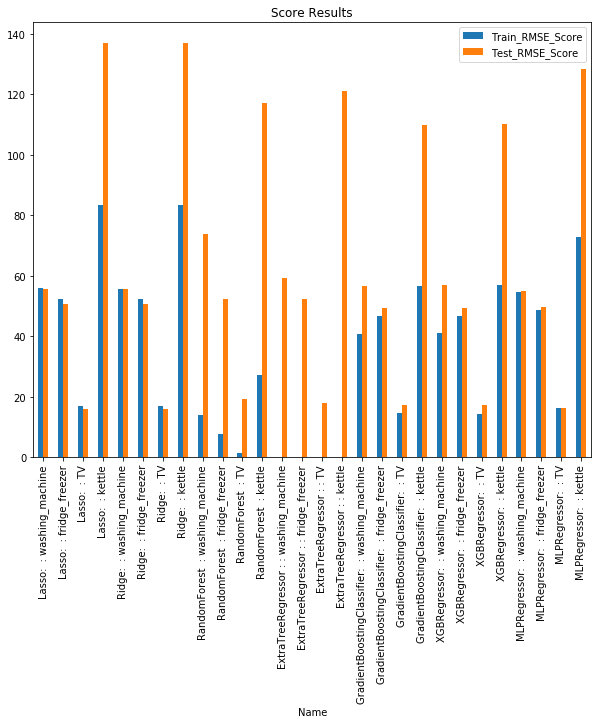

In [20]:
model_df.plot(x="Name", y=[ 'Train_RMSE_Score' , 'Test_RMSE_Score'], kind="bar" , title = 'Score Results' , figsize= (10,8)) 

### GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [{
              'max_depth': [80, 150, 200,250],
              'n_estimators' : [100,150,200,250],
              'max_features': ["auto", "sqrt", "log2"]
            }]
reg = ExtraTreesRegressor(random_state=40)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = reg, param_grid = param_grid, cv = 5, n_jobs = -1 , scoring='r2' , verbose=2)
grid_search.fit(train_X, train_y)

### Cros Validation

<img src="cross_val_TS.png",width=600,height=60>


In [110]:
from sklearn.model_selection import TimeSeriesSplit

In [128]:
from xgboost import XGBRegressor

tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(input_train):
    XG1 = XGBRegressor(max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    eta=0.3,    
    seed=42).fit(input_train.iloc[train_index], output_train.iloc[train_index]["washing_machine"])
    pred_XG1 = XG1.predict(input_train.iloc[test_index])
    score_XG1 = rmse(output_train.iloc[test_index]["washing_machine"], pred_XG1)
    print("score CV : ", score_XG1, "\n")


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:784: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:02:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
score CV :  49.53567463537415 

[11:04:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
score CV :  59.15598545270635 

[11:10:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
score CV :  58.37347127114004 



## For submission:

In [425]:
# create functions doing all previous steps

def preprocess(X):
    X.drop(["Unnamed: 9"], axis=1, inplace=True)
    to_interpolate = X.columns[-7:]
    X[to_interpolate] = pd.Series.interpolate(X[to_interpolate], method='linear', 
                                              limit=None, limit_direction='both')
    X.rename(columns = {X.columns[0]:'time_step'}, inplace=True)
    X['time_step'] = pd.to_datetime(X['time_step'])
    X['weekend'] = ((pd.DatetimeIndex(X['time_step']).dayofweek) // 5 == 1).astype(float)
    
     #tests
    X['month'] = X['time_step'].dt.month
    X['day_of_year'] = X['time_step'].dt.dayofyear
    #X['quarter'] = X['time_step'].dt.quarter remove because quasi-nul importance
    X['hour'] = X['time_step'].dt.hour
    X['week'] = X['time_step'].dt.week
    X['minute'] = X['time_step'].dt.minute
    
    
    X['weekday'] = X['time_step'].dt.weekday
    X = X.join(pd.get_dummies(X['weekday'], prefix='wd'))
    X['sin_time'] = np.sin(2*np.pi*X['time_step'].dt.hour/24)
    X['cos_time'] = np.cos(2*np.pi*X['time_step'].dt.hour/24)
    X.drop(['weekday'], axis=1, inplace=True)
    
   
    
    #Mean max and min consumption by (temperature, weekend, wd_0 etc.):
    groupcollist = ['hour', 'month', 'week', 'day_of_year', 'weekend', 'temperature', 'wind']
    aggregationlist = [('consumption',np.mean,'avg')]

    for type_id in groupcollist:
        for column_id,aggregator,aggtype in aggregationlist:
            # get numbers from sales data and set column names
            mean_df = X.groupby([type_id]).aggregate(aggregator).reset_index()[[column_id,type_id,]]
            mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id]
            # merge new columns on sales_m data
            X = pd.merge(X,mean_df,on=type_id,how='left')
            
    # Previous day same hour
    X['previous_day_same_hour'] = lagged_df['consumption'].shift(-1440) #1440 minutes/day   

            
    
    return X

In [440]:
input_test = pd.read_csv('X_test.csv')
X_test = preprocess(input_test)
X_test = X_test.drop('time_step', axis=1)

def predict(X, input_test, model_1, model_2, model_3, model_4)   :
    pred_1 = model_1.predict(X)
    pred_2 = model_2.predict(X)
    pred_3 = model_3.predict(X)
    pred_4 = model_4.predict(X)
    
    pred = pd.DataFrame()
    pred["time_step"] = input_test.time_step
    pred["washing_machine"] = pred_1
    pred["fridge_freezer"] = pred_2
    pred["TV"] = pred_3
    pred['kettle'] = pred_4
    
    pred.time_step = pred.time_step.apply(lambda x: x.strftime("%Y-%m-%dT%H:%M:%S.0"))
    
    return pred
Y_test_submit = predict(X_test, input_test, XG1, XG2, XG3, XG4)
Y_test_submit.to_csv('Y_test_features_more.csv', index=False)

Both the linear models and the random forests do not efficiently take into account the time nature of data. We need to find other models.

### Multi-output regressor

In [139]:
from sklearn.datasets import load_linnerud
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

def train(X, y):
    model = MultiOutputRegressor(XGBRegressor(), n_jobs=-1).fit(X, y)
    return model

model_MTR = train(input_train, output_train)

In [140]:
def predict(X, model):
    
    X.rename(columns = {X.columns[0]:'time_step'}, inplace=True)
    full_timesteps = pd.DataFrame(X['time_step'], columns=['time_step'])
    
    X = X.dropna() # need to remove all NaN to predict
    partial_timesteps = X['time_step']
    X.drop(['time_step'], axis=1, inplace=True)
    
    pred = model.predict(X)

    pred = pd.DataFrame(np.transpose([partial_timesteps, pred[:,0], pred[:,1], pred[:,2], pred[:,3]]),
                   columns=['time_step', 'washing_machine', 'fridge_freezer', 'TV', 'kettle'])

    pred.set_index(pred['time_step'], inplace=True)
    full_timesteps.set_index(full_timesteps['time_step'], inplace=True)
    pred = pred.merge(full_timesteps, left_index=True, right_index=True, how='outer')
    pred.drop(['time_step_x', 'time_step_y'], axis=1, inplace=True)
    pred.reset_index(inplace=True)
    pred = pred[['time_step', 'washing_machine', 'fridge_freezer', 'TV', 'kettle']].round(3)
    
    pred.time_step = pd.to_datetime(pred.time_step)
    pred.time_step = pred.time_step.apply(lambda x: x.strftime("%Y-%m-%dT%H:%M:%S.0"))
    
    return pred

# apply these functions to y_test.csv
input_test = pd.read_csv('X_test.csv')
X_test = preprocess(input_test)
Y_test_MTR = predict(X_test, model_MTR)
Y_test_MTR.to_csv('Y_test_XGBMOR.csv', index=False)
Y_test_MTR.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,time_step,washing_machine,fridge_freezer,TV,kettle
0,2014-01-01T00:00:00.0,14.1623,60.6998,16.4592,0.193406
1,2014-01-01T00:01:00.0,14.1623,60.6998,16.4544,0.193406
2,2014-01-01T00:02:00.0,14.1623,60.6998,16.3923,0.193406
3,2014-01-01T00:03:00.0,11.2134,60.6998,16.4592,0.193406
4,2014-01-01T00:04:00.0,11.2134,60.6998,16.4592,0.193406


## RNN with LSTM

In [362]:
import keras
from keras.layers.recurrent import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


In [374]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Activation


In [375]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

# drop columns we don't want to predict


In [376]:
y_train = pd.read_csv('y_train.csv')
y_train.time_step = pd.to_datetime(y_train['time_step'])
y_train = y_train.set_index('time_step')
to_interpolate = output_train.columns[-4:]
y_train[to_interpolate] = pd.Series.interpolate(y_train[to_interpolate],
                                                    method='linear', limit=None, 
                                                    limit_direction='both')
y_train.isna().sum()
# 2013-03-17 -> 2013-12-31

washing_machine    0
fridge_freezer     0
TV                 0
kettle             0
dtype: int64

In [377]:
values = input_train.values[:,]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_x = scaler.fit_transform(values)
reframed_x = (series_to_supervised(scaled_x, 1, 1)).values

values_y = y_train.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler.fit_transform(values_y)
reframed_y = (series_to_supervised(scaled_y, 1, 1)).values

In [378]:
train_X, train_y = reframed_x[:300000,:18], reframed_y[:300000,:4]
test_X, test_y = reframed_x[300001:,:18], reframed_y[300001:,:4]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(300000, 1, 18) (300000, 4) (117597, 1, 18) (117597, 4)


In [379]:
print(train_X)

[[[0.05952937 0.46666667 0.41304348 ... 1.         0.5        1.        ]]

 [[0.05928826 0.46666667 0.41304348 ... 1.         0.5        1.        ]]

 [[0.05938202 0.46666667 0.41304348 ... 1.         0.5        1.        ]]

 ...

 [[0.05591643 0.05982222 0.31987578 ... 0.         0.98296291 0.37059048]]

 [[0.07966465 0.05924444 0.31987578 ... 0.         0.98296291 0.37059048]]

 [[0.05151506 0.05866667 0.31987578 ... 0.         0.9330127  0.25      ]]]


In [380]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(4))
#model.add(Activation('softmax'))
model.compile(loss='rmse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=5, batch_size=64,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

In [373]:
import matplotlib.pyplot as pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

NameError: name 'history' is not defined

In [56]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                13800     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 204       
Total params: 14,004
Trainable params: 14,004
Non-trainable params: 0
_________________________________________________________________


In [90]:
yhat = model.predict(test_X).clip(min=0)
#t_X = test_X.copy().reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
#inv_yhat = np.concatenate((yhat, t_X[:, 1:]), axis=1)
#inv_yhat = scaler.inverse_transform(yhat)
#inv_yhat = inv_yhat[:,0:2]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 4))
#inv_y = np.concatenate((test_y, t_X[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(test_y)
#inv_y = inv_y[:,0:2]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.106


In [89]:
yhat

array([[9.1351103e-06, 1.7527532e-02, 3.3907115e-02, 3.1384930e-04],
       [6.0838065e-05, 2.3467127e-02, 3.3969309e-02, 3.7947809e-04],
       [7.9366931e-05, 2.5569184e-02, 3.3991110e-02, 4.0247489e-04],
       ...,
       [2.9330509e-04, 5.2750792e-02, 3.4352355e-02, 3.4039773e-04],
       [2.9256105e-04, 5.2660763e-02, 3.4351595e-02, 3.3979130e-04],
       [2.9361842e-04, 5.2788686e-02, 3.4352675e-02, 3.4065315e-04]],
      dtype=float32)

In [93]:
def predict_rnn(X, model):
    X.rename(columns = {X.columns[0]:'time_step'}, inplace=True)
    full_timesteps = pd.DataFrame(X['time_step'], columns=['time_step'])
    X = X.dropna() # need to remove all NaN to predict
    partial_timesteps = X['time_step']
    X.drop(['time_step'], axis=1, inplace=True)
    X = X.values.reshape((X.shape[0], 1, X.shape[1]))
    pred = model.predict(X)
    pred = pd.DataFrame(np.transpose([partial_timesteps, pred[:,0], pred[:,1], pred[:,2], pred[:,3]]),
                   columns=['time_step', 'washing_machine', 'fridge_freezer', 'TV', 'kettle'])
    pred.set_index(pred['time_step'], inplace=True)
    full_timesteps.set_index(full_timesteps['time_step'], inplace=True)
    pred = pred.merge(full_timesteps, left_index=True, right_index=True, how='outer')
    pred.drop(['time_step_x', 'time_step_y'], axis=1, inplace=True)
    pred.reset_index(inplace=True)
    pred = pred[['time_step', 'washing_machine', 'fridge_freezer', 'TV', 'kettle']].round(3)
    pred.time_step = pd.to_datetime(pred.time_step)
    pred.time_step = pred.time_step.apply(lambda x: x.strftime("%Y-%m-%dT%H:%M:%S.0"))
    return pred

In [95]:
X_test

,time_step,visibility,temperature,humidity,humidex,windchill,wind,pressure,weekend,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,sin_time,cos_time
0,312.2222,30.00,8.400000,86.000000,8.400000,5.600000,17.0,1016.600,0.0,0,0,1,0,0,0,0,0.000000,1.000000
1,318.8750,29.95,8.401667,85.983333,8.401667,5.616667,16.9,1016.615,0.0,0,0,1,0,0,0,0,0.000000,1.000000
2,314.3000,29.90,8.403333,85.966667,8.403333,5.633333,16.8,1016.630,0.0,0,0,1,0,0,0,0,0.000000,1.000000
3,311.4444,29.85,8.405000,85.950000,8.405000,5.650000,16.7,1016.645,0.0,0,0,1,0,0,0,0,0.000000,1.000000
4,310.0000,29.80,8.406667,85.933333,8.406667,5.666667,16.6,1016.660,0.0,0,0,1,0,0,0,0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226076,176.0000,14.24,8.433333,90.000000,8.440000,4.346667,31.0,1019.940,0.0,0,0,0,0,1,0,0,-0.258819,0.965926
226077,176.3333,14.43,8.425000,90.000000,8.430000,4.335000,31.0,1019.955,0.0,0,0,0,0,1,0,0,-0.258819,0.965926
226078,174.8889,14.62,8.416667,90.000000,8.420000,4.323333,31.0,1019.970,0.0,0,0,0,0,1,0,0,-0.258819,0.965926
226079,189.3750,14.81,8.408333,90.000000,8.410000,4.311667,31.0,1019.985,0.0,0,0,0,0,1,0,0,-0.258819,0.965926


In [96]:
input_test = pd.read_csv('X_test.csv')
X_test = preprocess(input_test)
Y_test_rnn = predict_rnn(X_test, model)

# checks
print(input_test.shape)
print(X_test.shape)
print(Y_test_rnn.shape)
print(Y_test_rnn.head())

# write to csv for upload on website
Y_test_rnn.to_csv('Y_test_RNN_wola.csv', index=False)

/Users/netflix/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(226081, 11)
(226081, 19)
(226081, 5)
               time_step washing_machine fridge_freezer       TV       kettle
0  2014-01-01T00:00:00.0     0.000384292       0.049966  0.03424  0.000523488
1  2014-01-01T00:01:00.0     0.000384292       0.049966  0.03424  0.000523488
2  2014-01-01T00:02:00.0     0.000384292       0.049966  0.03424  0.000523488
3  2014-01-01T00:03:00.0     0.000384292       0.049966  0.03424  0.000523488
4  2014-01-01T00:04:00.0     0.000384292       0.049966  0.03424  0.000523488


### NILM disaggregation algorithms

**LOTS OF WORK REQUIRED TO ADAPT TO THIS LIBRARY...**

We tried to use tools provided by the [NILMTK](https://github.com/nilmtk/nilmtk) library (Non Intrusive Load Monitoring Toolkit). See from documentation: [disaggregation and metrics](https://github.com/nilmtk/nilmtk/blob/master/docs/manual/user_guide/disaggregation_and_metrics.ipynb), [data grouping and basic statistics](https://github.com/nilmtk/nilmtk/blob/master/docs/manual/user_guide/elecmeter_and_metergroup.ipynb).

Disaggegration algorithms in NILMTK are implemented as python classes, with **_4 algorithms_** provided: **Combinatorial optimisation (CO)**, **FHMM - factorial hidden Markov model** (using exact inference), an implementation of **George Hart's 1985 disaggregation algorithm**, and a **Maximum Likelihood Estimation** algorithm.

**_Training_**  
The disaggregation algorithm is trained either from appliance-level data from the building which will be disaggregated ("supervised" method) or from other buildings ("unsupervised" method). The `train()` method expects a `MeterGroup` object to be passed as a parameter containing a list of `ElecMeter` objects. Algorithms should specify if a `site_meter` is also required to be present in the `MeterGroup` object. Training iterates over chunks of data, passing each chunk to the `train_on_chunk()` method. Successive calls to `train_on_chunk()` update the existing model. The models learned via `train()` are held in volatile memory, and therefore will be lost once the disaggregator object has been destroyed. Persistent models can be implemented via the `import_model()` and `export_model()` methods, which will load a model from disk (replacing any in-memory model) and save an in-memory model to disk respectively. This allows learned models to be applied to large numbers of buildings without repeating the training process.

**_Prediction (disaggregation)_**  
The `disaggregate()` method uses a learned model to separate a `site_meter`'s load into individual appliances. As with training, the `disaggregate()` method should iterate over chunks of aggregate data, calling `disaggregate_chunk()` on each chunk. The `disaggregate_chunk()` method returns a pandas dataframe, where the columns correspond to individual appliances and the rows correspond to instants in time. The returned dataframe's indexes should exactly match that of the dataframe received as a parameter. The `disaggregate()` method saves each disaggregated chunk to disk via the `datastore.append()` method, along with the required metadata.

In [54]:
!conda install -c nilmtk nilmtk

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: - 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
                                                                               failed

UnsatisfiableError: The following specifications were found to be incompatible with each other:

Output in format: Requested package -> Available versions



In [ ]:
from __future__ import print_function, division
import time
from six import iteritems

# to first install nilmtk, in terminal :
# conda config --add channels conda-forge
# conda install -c nilmtk nilmtk
import nilmtk
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

A function to disaggregate the total data to constituent appliances and return the predictions:

In [ ]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}
    
    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.    
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'apparent', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

#gt, predictions[clf_name] = predict(clf, test_elec, sample_period, None)

Train using 2 benchmarking algorithms - Combinatorial Optimisation (CO) and Factorial Hidden Markov Model (FHMM):

In [ ]:
classifiers = {'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}
predictions = {}
sample_period = 120
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    # Note that we have given the sample period to downsample the data to 1 minute. 
    # If instead of top_5 we wanted to train on all appliance, we would write 
    # fhmm.train(train_elec, sample_period=60)
    clf.train(output_train, sample_period=sample_period)

### Time series forecasting using only Y

In [290]:
y_train = pd.read_csv('y_train.csv')
y_train.time_step = pd.to_datetime(y_train['time_step'])
y_train = y_train.set_index('time_step')
to_interpolate = output_train.columns[-4:]
y_train[to_interpolate] = pd.Series.interpolate(y_train[to_interpolate],
                                                    method='linear', limit=None, 
                                                    limit_direction='both')
y_train.isna().sum()
# 2013-03-17 -> 2013-12-31

washing_machine    0
fridge_freezer     0
TV                 0
kettle             0
dtype: int64

In [291]:
#Y_test to predict: 2014-01-01 -> 2014-06-07
X_test = pd.read_csv('X_test.csv')
full_timesteps = pd.DataFrame(X_test['time_step'], columns=['time_step'])

In [292]:
y_train.head()

,washing_machine,fridge_freezer,TV,kettle
time_step,,,,
2013-03-17 00:01:00,0.0,79.2000,7.0,0.0
2013-03-17 00:02:00,0.0,78.0000,7.0,0.0
2013-03-17 00:03:00,0.0,76.9000,7.0,0.0
2013-03-17 00:04:00,0.0,76.1111,7.0,0.0
2013-03-17 00:05:00,0.0,75.2727,7.0,0.0


In [329]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [359]:
#Train/Test split of y_train
data = y_train
train = data[:int(0.8*(len(data)))]
test = data[int(0.8*(len(data))):]
cols = data.columns
#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = SARIMAX(endog=train.TV)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(len(test))

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency T will be used.

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency T will be used.



In [360]:
yhat = pd.DataFrame(prediction, columns = ['TV'])
#y_forecast = pd.concat([pd.Series(test.index), yhat], axis=1)
yhat = yhat.reset_index().rename(columns={'index':'time_step'})
yhat.head()

,time_step,TV
0,2013-11-04 00:00:00,6.956418
1,2013-11-04 00:01:00,6.913107
2,2013-11-04 00:02:00,6.870066
3,2013-11-04 00:03:00,6.827293
4,2013-11-04 00:04:00,6.784786


In [361]:
score_fore = rmse(np.array(test["TV"]), yhat.TV)
score_fore

22.36709695021392

### Final Preds

In [294]:
#make final predictions
model = VAR(endog=data)
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.y, steps=226081 )
print(yhat)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency T will be used.

/anaconda3/lib/python3.6/site-packages/statsmodels/base/wrapper.py:36: FutureWarning:

y is a deprecated alias for endog, will be removed in version 0.11.0



[[ 1.47666319  2.02130243 64.81298882  5.34615283]
 [ 2.35464732  3.96201444 64.29889264  7.57182252]
 [ 2.8803253   5.8246052  63.79061119  8.49245995]
 ...
 [ 5.77773947 49.93682391 14.49599786  5.0003242 ]
 [ 5.77773947 49.93682391 14.49599786  5.0003242 ]
 [ 5.77773947 49.93682391 14.49599786  5.0003242 ]]


In [300]:
yhat = pd.DataFrame(yhat, columns = y_train.columns)

In [301]:
y_forecast = pd.concat([full_timesteps, yhat], axis=1)
y_forecast.head(2)

,time_step,washing_machine,fridge_freezer,TV,kettle
0,2014-01-01T00:00:00.0,1.476663,2.021302,64.812989,5.346153
1,2014-01-01T00:01:00.0,2.354647,3.962014,64.298893,7.571823


### Our final model: xxx

## Test metric

The metric we will use is (Wh) :
$$
\mathcal{L}(\widehat{y}, y) = \frac{1}{\sum_{j \: in \: appliances} \alpha_j} \sum_{j \: in \: appliances} \alpha_j \sqrt{\frac{\sum_{i=1}^{N} (\widehat{y}_{i}^{(j)}-y_{i}^{(j)})^2)}{N}}
$$

Where
* N = 201362 : number of data known in test set
* appliances = \{washing_machine, fridge_freezer, TV, kettle\}
* $\alpha_j = E(y_{i}^{(j)})$ : mean of power of the appliance j on training set
     * $\alpha_{washing\_machine} = 5.55$
     * $\alpha_{fridge_freezer} = 49.79$
     * $\alpha_{TV} = 14.57$
     * $\alpha_{kettle} = 4.95$

In [ ]:
import pandas as pd
import datetime as dt
import math as mt

def metric_nilm(dataframe_y_true, dataframe_y_pred):
    score = 0.0
    test = dataframe_y_true[~dataframe_y_true['washing_machine'].isna()]['washing_machine']
    pred = dataframe_y_pred[~dataframe_y_true['washing_machine'].isna()]['washing_machine']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*5.55
    test = dataframe_y_true[~dataframe_y_true['fridge_freezer'].isna()]['fridge_freezer']
    pred = dataframe_y_pred[~dataframe_y_true['fridge_freezer'].isna()]['fridge_freezer']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*49.79
    test = dataframe_y_true[~dataframe_y_true['TV'].isna()]['TV']
    pred = dataframe_y_pred[~dataframe_y_true['TV'].isna()]['TV']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*14.57
    test = dataframe_y_true[~dataframe_y_true['kettle'].isna()]['kettle']
    pred = dataframe_y_pred[~dataframe_y_true['kettle'].isna()]['kettle']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*4.95
    score /= 74.86
    return score

if __name__ == '__main__':
    import pandas as pd
    CSV_FILE_Y_TRUE = 'y_test.csv'
    CSV_FILE_Y_PRED = 'y_pred.csv'
    df_y_true = pd.read_csv(CSV_FILE_Y_TRUE, index_col=0, sep=',')
    df_y_pred = pd.read_csv(CSV_FILE_Y_PRED, index_col=0, sep=',')
    if df_y_true.shape[0] == df_y_pred.shape[0] :
        df_y_true = df_y_true.sort_values(by=['time_step'])
        df_y_pred = df_y_pred.sort_values(by=['time_step'])
        if (df_y_true.index[0]== df_y_pred.index[0]) & (df_y_true.index[df_y_true.shape[0]-1]== df_y_pred.index[df_y_pred.shape[0]-1]) :
            df_y_true['washing_machine'] = pd.to_numeric(df_y_true['washing_machine'], errors = 'nan')
            df_y_true['fridge_freezer'] = pd.to_numeric(df_y_true['fridge_freezer'], errors = 'nan')
            df_y_true['TV'] = pd.to_numeric(df_y_true['TV'], errors = 'nan')
            df_y_true['kettle'] = pd.to_numeric(df_y_true['kettle'], errors = 'nan')
            df_y_pred['washing_machine'] = pd.to_numeric(df_y_pred['washing_machine'], errors = 'nan')
            df_y_pred['fridge_freezer'] = pd.to_numeric(df_y_pred['fridge_freezer'], errors = 'nan')
            df_y_pred['TV'] = pd.to_numeric(df_y_pred['TV'], errors = 'nan')
            df_y_pred['kettle'] = pd.to_numeric(df_y_pred['kettle'], errors = 'nan')
            print(metric_nilm(df_y_true, df_y_pred))
        else :
            print('nan')
    else :
            print('nan')